# ui.slack

> Fill in a module description here

- [Block Kit](https://api.slack.com/block-kit)
- https://api.slack.com/events/message?filter=Events
- https://slack.dev/bolt-python/concepts
- https://www.dataquest.io/wp-content/uploads/2019/03/python-regular-expressions-cheat-sheet.pdf

In [ ]:
#| default_exp ui.slack

In [ ]:
#| hide
from nbdev.showdoc import *
%reload_ext autoreload
%autoreload 2

In [ ]:
#| export
import re
import os
import PIL
import uuid
from PIL import Image
import requests
import io
import base64
import logging
from typing import List
from pprint import pprint, pformat
import pysnooper


logger = logging.getLogger()
logger.setLevel(logging.INFO)

# extract config from raw text

In [ ]:
#| export
def get_key_val(text: str, sep=":") -> dict:
    params = {}
    k, v = [s.strip() for s in text.split(sep)]

    # try:
    #     params[k] = int(v.replace(",", ''))
    # except ValueError:
    #     params[k] = v.replace(",", '')
        
    params[k] = v.replace(",", '')    
    
    return params

In [ ]:
#| export
def parse_raw_text(text: str) -> dict:

    text = re.sub("<@U.*>", "", text)

    params = {}
    # param_key_with_colons = re.findall("[\s,]\w*:\w*[\s,]", text)
    param_key_with_colons = re.findall(f"\w+:\s*[\w.]+", text)
    n = len(param_key_with_colons)
    
    if n == 0 and text:
        params['prompt'] = text.strip()
    elif n > 0:
        remained_text = str(text)
        if n > 1:
            for i, p in enumerate(param_key_with_colons[:-1]):
                start = text.index(p)
                end = text.index(param_key_with_colons[i+1])
                partial_text = text[start: end]
                params.update(get_key_val(partial_text))
                remained_text = remained_text.replace(partial_text, "")
        
        start = text.index(param_key_with_colons[-1])
        end = start + len(param_key_with_colons[-1])
        partial_text = text[start: end]
        params.update(get_key_val(partial_text))
        remained_text = remained_text.replace(partial_text, "")
        
        params['prompt'] = remained_text.strip()
        
    else:
        pass
        # print(f"param_key_with_colons: {param_key_with_colons}")
        # raise NotImplementedError
    

    return params

In [ ]:
text = " my prompt steps: 10, cfg:6\nseed:  234928347\n"
d = parse_raw_text(text)
assert d == {'steps': '10', 'cfg': '6', 'seed': '234928347', 'prompt': 'my prompt'}

# parse rich text

In [ ]:
#| export
NS = "negative_sentences"
NP = "negative_prompt"
P = "prompt"

GATHERING_PROMPT = "gathering"
STOP_PARSING = "stop"
INTERMEDIATE_KEYS = [GATHERING_PROMPT, STOP_PARSING, NS]

## parse_rich_text_section

In [ ]:
#| export
# @pysnooper.snoop()
def parse_rich_text_section(element: dict, bot_user_id: str=None, kv_sep=":", is_bullet=False) -> dict:
    
    if not element['type'] in ['rich_text_section', 'rich_text_quote']:
        raise NotImplementedError(pformat(element))
    
    if not bot_user_id and not is_bullet:
        raise ValueError("either `bot_user_id` need to be set or `is_bullet` be True")
    
    d = {}
    partial_prompts = []
    negative_words = []
    bot_mention_found = False
    
    if is_bullet:
        e = element["elements"][0]
        style = e.get("style", {})
        text = e["text"]
        if style and style.get("strike", False):
            logging.info(f"Found negative prompt.")
            negative_words.append(text.strip())                
                
        elif e['type'] == "text" and e.get('text', None):
            logging.info(f"try parsing key value using {kv_sep} separator.")
            
            param_key_with_colons = re.findall(f"\w+{kv_sep}\s*[\w.]+", text)
            # logger.info(f"param_key_with_colons: {param_key_with_colons}")
            for s in param_key_with_colons:
                parts = s.split(kv_sep)
                k, v = parts[0], parts[1]
                d[k.strip()] = v.strip()
        else:
            raise NotImplementedError(e)
    
    else:
        for i, e in enumerate(element['elements']):
            etype = e['type']
            text = e.get("text", None)
            style = e.get("style", {})
            
            if style and style.get("strike", False):
                logging.info(f"Found negative prompt.")
                negative_words.append(text.strip())
            elif etype == "text":
                text = " ".join(re.sub("\s", " ", e['text']).split())
                partial_prompts += [text]
            elif etype == 'user':
                if e['user_id'] == bot_user_id:
                    # clean all previously collected result 
                    partial_prompts = []
                    negative_words = []
                    d = {GATHERING_PROMPT: True}
                    bot_mention_found = True
                else:
                    logging.info(f"Assume only the text after user_id:{bot_user_id} and before another user contains prompt")
                    d.pop(GATHERING_PROMPT, False)
                    d[STOP_PARSING] = True
                    
                    if bot_mention_found:
                        break
                    
            

    if partial_prompts:
        raw_prompt = " ".join([p for p in partial_prompts if p.strip()])
        parsed_from_raw_prompt = parse_raw_text(raw_prompt)
        d.update(parsed_from_raw_prompt)
    if negative_words:
        d[NS] = negative_words
    
    
    return d

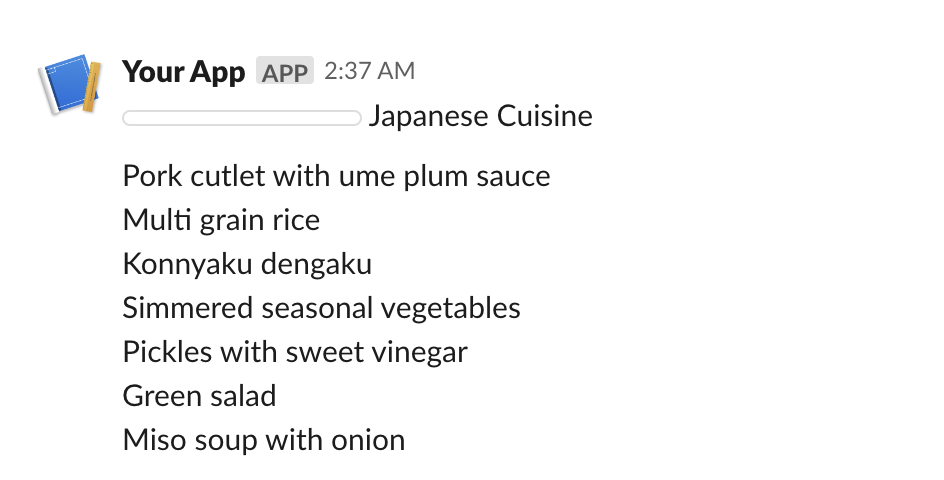

- [Block Kit Builder](https://app.slack.com/block-kit-builder/T0W4GV482#%7B%22blocks%22:%5B%7B%22block_id%22:%22Syg7X%22,%22elements%22:%5B%7B%22elements%22:%5B%7B%22type%22:%22user%22,%22user_id%22:%22U046NC74JTV%22%7D,%7B%22text%22:%22%20Japanese%20Cuisine%5Cn%5CnPork%20cutlet%20with%20ume%20plum%20sauce%5CnMulti%20grain%20rice%5CnKonnyaku%20dengaku%5CnSimmered%20seasonal%20vegetables%5CnPickles%20with%20sweet%20vinegar%5CnGreen%20salad%5CnMiso%20soup%20with%20onion%22,%22type%22:%22text%22%7D%5D,%22type%22:%22rich_text_section%22%7D%5D,%22type%22:%22rich_text%22%7D%5D%7D)

In [ ]:
e = {
    "elements": [
        {
            "type": "user",
            "user_id": "U046NC74JTV"
        },
        {
            "text": " Japanese Cuisine\n\nPork cutlet with ume plum sauce\nMulti grain rice",
            "type": "text"
        }
    ],
    "type": "rich_text_section"
}

d = parse_rich_text_section(e, bot_user_id="U046NC74JTV")
d
assert d == {GATHERING_PROMPT: True,
 'prompt': 'Japanese Cuisine Pork cutlet with ume plum sauce Multi grain rice'}

In [ ]:
e = {'elements': [{'text': 'steps: 50', 'type': 'text'}], 'type': 'rich_text_section'}
d = parse_rich_text_section(e, is_bullet=True)
d
assert d == {'steps': '50'}

INFO:root:try parsing key value using : separator.


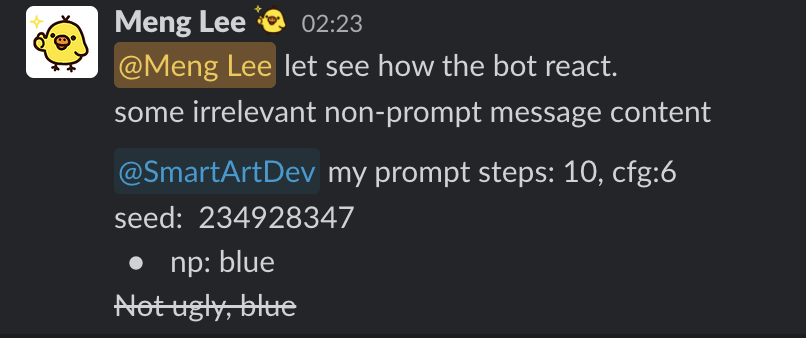

In [ ]:
e = {
    "elements": [
        {
            "type": "user",
            "user_id": "UB97SPZRT"
        },
        {
            "text": " let see how the bot react.\nsome irrelevant non-prompt message content\n\n",
            "type": "text"
        },
        {
            "type": "user",
            "user_id": "U046NC74JTV"
        },
        {
            "text": " my prompt steps: 10, cfg:6.5\nseed:  234928347\n",
            "type": "text"
        }
    ],
    "type": "rich_text_section"
}
d = parse_rich_text_section(e, bot_user_id="U046NC74JTV")
d
assert d == {GATHERING_PROMPT: True,
 'steps': '10',
 'cfg': '6.5',
 'seed': '234928347',
 'prompt': 'my prompt'}

INFO:root:Assume only the text after user_id:U046NC74JTV and before another user contains prompt


In [ ]:
e = {
    "elements": [
        {
            "style": {
                "strike": True
            },
            "text": "Not ugly, blue",
            "type": "text"
        }
    ],
    "type": "rich_text_section"
}
d = parse_rich_text_section(e, bot_user_id="U046NC74JTV")
assert d == {NS: ['Not ugly, blue']}

INFO:root:Found negative prompt.


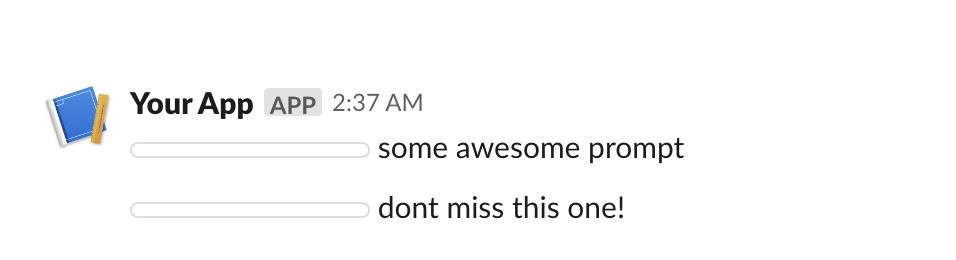

- [Block Kit Builder](https://app.slack.com/block-kit-builder/T0W4GV482#%7B%22blocks%22:%5B%7B%22block_id%22:%22c+Q3o%22,%22elements%22:%5B%7B%22elements%22:%5B%7B%22type%22:%22user%22,%22user_id%22:%22U046NC74JTV%22%7D,%7B%22text%22:%22%20some%20awesome%20prompt%5Cn%5Cn%22,%22type%22:%22text%22%7D,%7B%22type%22:%22user%22,%22user_id%22:%22UB97SPZRT%22%7D,%7B%22text%22:%22%20dont%20miss%20this%20one!%22,%22type%22:%22text%22%7D%5D,%22type%22:%22rich_text_section%22%7D%5D,%22type%22:%22rich_text%22%7D%5D%7D)

In [ ]:
e = {
    "elements": [
        {
            "type": "user",
            "user_id": "U046NC74JTV"
        },
        {
            "text": " some awesome prompt\n\n",
            "type": "text"
        },
        {
            "type": "user",
            "user_id": "UB97SPZRT"
        },
        {
            "text": " dont miss this one!",
            "type": "text"
        }
    ],
    "type": "rich_text_section"
}
d = parse_rich_text_section(e, bot_user_id="U046NC74JTV")
d
assert d == {STOP_PARSING: True, 'prompt': 'some awesome prompt'}

INFO:root:Assume only the text after user_id:U046NC74JTV and before another user contains prompt


## parse_rich_text_quote

In [ ]:
#| export
def parse_rich_text_quote(element: dict, bot_user_id: str=None, kv_sep=":", is_bullet=False) -> dict:
    return parse_rich_text_section(element, bot_user_id=bot_user_id, is_bullet=is_bullet)

## parse_rich_text_list

In [ ]:
#| export
# @pysnooper.snoop()
def parse_rich_text_list(element: dict) -> dict:
    if not (element['type'] == 'rich_text_list' and element['style'] == "bullet"):
        raise NotImplementedError(pformat(element))
    
    d = {}
    
    for e in element["elements"]:
        partial_d = parse_rich_text_section(e, is_bullet=True)
        d.update(partial_d)
    
    return d

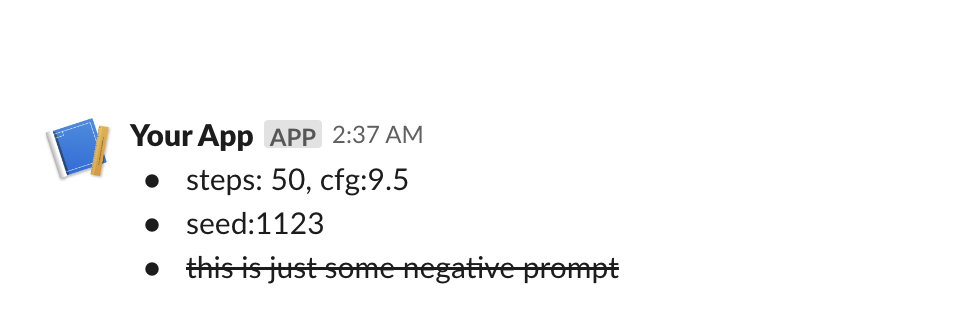

- [Block Kit Builder](https://app.slack.com/block-kit-builder/T0W4GV482#%7B%22blocks%22:%5B%7B%22block_id%22:%22NUEAU%22,%22elements%22:%5B%7B%22border%22:0,%22elements%22:%5B%7B%22elements%22:%5B%7B%22text%22:%22steps:%2050,%20cfg:9.5%22,%22type%22:%22text%22%7D%5D,%22type%22:%22rich_text_section%22%7D,%7B%22elements%22:%5B%7B%22text%22:%22seed:1123%22,%22type%22:%22text%22%7D%5D,%22type%22:%22rich_text_section%22%7D,%7B%22elements%22:%5B%7B%22style%22:%7B%22strike%22:true%7D,%22text%22:%22this%20is%20just%20some%20negative%20prompt%22,%22type%22:%22text%22%7D%5D,%22type%22:%22rich_text_section%22%7D%5D,%22indent%22:0,%22style%22:%22bullet%22,%22type%22:%22rich_text_list%22%7D,%7B%22elements%22:%5B%5D,%22type%22:%22rich_text_section%22%7D%5D,%22type%22:%22rich_text%22%7D%5D%7D)

In [ ]:
e = {
    "border": 0,
    "elements": [
        {
            "elements": [
                {
                    "text": "steps: 50, cfg:9.5",
                    "type": "text"
                }
            ],
            "type": "rich_text_section"
        },
        {
            "elements": [
                {
                    "text": "seed:1123",
                    "type": "text"
                }
            ],
            "type": "rich_text_section"
        },
        {
            "elements": [
                {
                    "style": {
                        "strike": True
                    },
                    "text": "this is just some negative prompt",
                    "type": "text"
                }
            ],
            "type": "rich_text_section"
        }
    ],
    "indent": 0,
    "style": "bullet",
    "type": "rich_text_list"
}

d = parse_rich_text_list(e)
d
assert d == {
    NS: ['this is just some negative prompt'],
    'steps': '50',
    'cfg': '9.5',
    'seed': '1123'
}

INFO:root:try parsing key value using : separator.
INFO:root:try parsing key value using : separator.
INFO:root:Found negative prompt.


## parse_rich_text

In [ ]:
#| export
# @pysnooper.snoop()
def parse_rich_text(element: dict, bot_user_id: str=None) -> dict:
    if not element['type'] == 'rich_text':
        raise NotImplementedError(pformat(element))
    
    d = {}
    for e in element['elements']:
        etype = e['type']
        
        if etype == 'rich_text_section':
            dd = parse_rich_text_section(e, bot_user_id=bot_user_id)
        elif etype == "rich_text_quote":
            dd = parse_rich_text_quote(e, bot_user_id=bot_user_id)
        elif etype == 'rich_text_list':
            dd = parse_rich_text_list(e)
        else:
            raise NotImplementedError(pformat(e))
        
        logger.info(f"Partial result from parsing {pformat(e)}:")
        logger.info(pformat(dd))
        
         # aggresive sstop
        if STOP_PARSING in dd:
            break
        
        for k, v in dd.items():
            if not k in d:
                d[k] = v
            elif k in d:
                if isinstance(d[k], list):
                    d[k].extend(v)
                else:
                    d[k] = v
                    
            else:
                raise NotImplementedError(f"partial result of {pformat(e)}: {pformat(dd)}")
            
    logger.info("Result by parsing `rich_text` element:")
    logger.info(pformat(d))
    return d
    
    

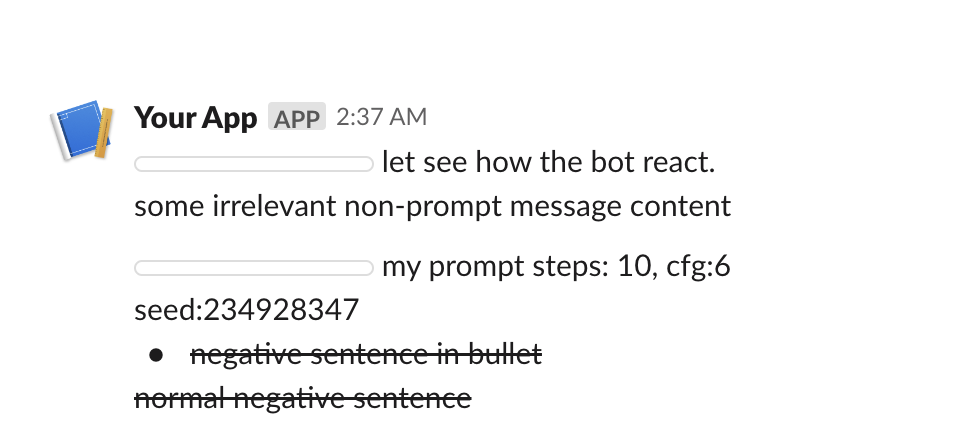

- [Block Kit Builder](https://app.slack.com/block-kit-builder/T0W4GV482#%7B%22blocks%22:%5B%7B%22block_id%22:%22ANXeP%22,%22elements%22:%5B%7B%22elements%22:%5B%7B%22type%22:%22user%22,%22user_id%22:%22UB97SPZRT%22%7D,%7B%22text%22:%22%20let%20see%20how%20the%20bot%20react.%5Cnsome%20irrelevant%20non-prompt%20message%20content%5Cn%5Cn%22,%22type%22:%22text%22%7D,%7B%22type%22:%22user%22,%22user_id%22:%22U046NC74JTV%22%7D,%7B%22text%22:%22%20my%20prompt%20steps:%2010,%20cfg:6%5Cnseed:234928347%5Cn%22,%22type%22:%22text%22%7D%5D,%22type%22:%22rich_text_section%22%7D,%7B%22border%22:0,%22elements%22:%5B%7B%22elements%22:%5B%7B%22style%22:%7B%22strike%22:true%7D,%22text%22:%22negative%20sentence%20in%20bullet%22,%22type%22:%22text%22%7D%5D,%22type%22:%22rich_text_section%22%7D%5D,%22indent%22:0,%22style%22:%22bullet%22,%22type%22:%22rich_text_list%22%7D,%7B%22elements%22:%5B%7B%22style%22:%7B%22strike%22:true%7D,%22text%22:%22normal%20negative%20sentence%22,%22type%22:%22text%22%7D%5D,%22type%22:%22rich_text_section%22%7D%5D,%22type%22:%22rich_text%22%7D%5D%7D)

In [ ]:
e = {
    "block_id": "ANXeP",
    "elements": [
        {
            "elements": [
                {
                    "type": "user",
                    "user_id": "UB97SPZRT"
                },
                {
                    "text": " let see how the bot react.\nsome irrelevant non-prompt message content\n\n",
                    "type": "text"
                },
                {
                    "type": "user",
                    "user_id": "U046NC74JTV"
                },
                {
                    "text": " my prompt steps: 10, cfg:6\nseed:234928347\n",
                    "type": "text"
                }
            ],
            "type": "rich_text_section"
        },
        {
            "border": 0,
            "elements": [
                {
                    "elements": [
                        {
                            "style": {
                                "strike": True
                            },
                            "text": "negative sentence in bullet",
                            "type": "text"
                        }
                    ],
                    "type": "rich_text_section"
                }
            ],
            "indent": 0,
            "style": "bullet",
            "type": "rich_text_list"
        },
        {
            "elements": [
                {
                    "style": {
                        "strike": True
                    },
                    "text": "normal negative sentence",
                    "type": "text"
                }
            ],
            "type": "rich_text_section"
        }
    ],
    "type": "rich_text"
}

d = parse_rich_text(e, bot_user_id="U046NC74JTV")
d
assert d == {
    GATHERING_PROMPT: True,
    'steps': '10',
    'cfg': '6',
    'seed': '234928347',
    'prompt': 'my prompt',
    NS: ['negative sentence in bullet', 'normal negative sentence']}

INFO:root:Assume only the text after user_id:U046NC74JTV and before another user contains prompt
INFO:root:Partial result from parsing {'elements': [{'type': 'user', 'user_id': 'UB97SPZRT'},
              {'text': ' let see how the bot react.\n'
                       'some irrelevant non-prompt message content\n'
                       '\n',
               'type': 'text'},
              {'type': 'user', 'user_id': 'U046NC74JTV'},
              {'text': ' my prompt steps: 10, cfg:6\nseed:234928347\n',
               'type': 'text'}],
 'type': 'rich_text_section'}:
INFO:root:{'cfg': '6',
 'gathering': True,
 'prompt': 'my prompt',
 'seed': '234928347',
 'steps': '10'}
INFO:root:Found negative prompt.
INFO:root:Partial result from parsing {'border': 0,
 'elements': [{'elements': [{'style': {'strike': True},
                             'text': 'negative sentence in bullet',
                             'type': 'text'}],
               'type': 'rich_text_section'}],
 'indent': 0,
 'style'

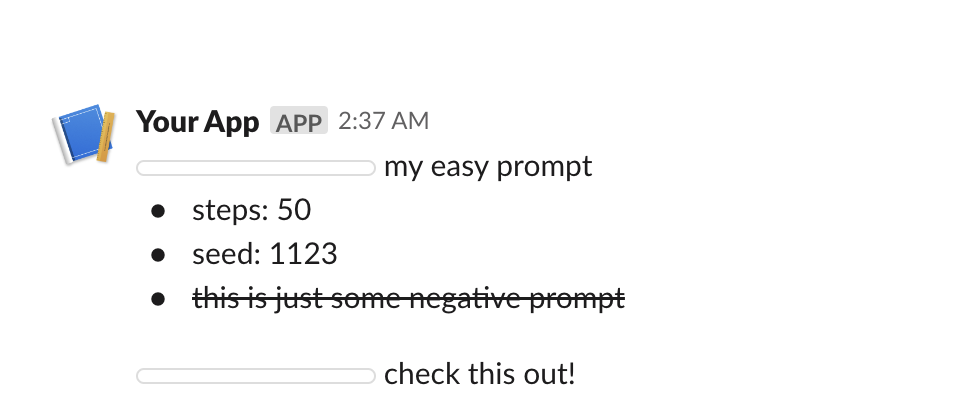

- [Block Kit Builder](https://app.slack.com/block-kit-builder/T0W4GV482#%7B%22blocks%22:%5B%7B%22block_id%22:%22G0Y89%22,%22elements%22:%5B%7B%22elements%22:%5B%7B%22type%22:%22user%22,%22user_id%22:%22U046NC74JTV%22%7D,%7B%22text%22:%22%20my%20easy%20prompt%5Cn%22,%22type%22:%22text%22%7D%5D,%22type%22:%22rich_text_section%22%7D,%7B%22border%22:0,%22elements%22:%5B%7B%22elements%22:%5B%7B%22text%22:%22steps:%2050%22,%22type%22:%22text%22%7D%5D,%22type%22:%22rich_text_section%22%7D,%7B%22elements%22:%5B%7B%22text%22:%22seed:%201123%22,%22type%22:%22text%22%7D%5D,%22type%22:%22rich_text_section%22%7D,%7B%22elements%22:%5B%7B%22style%22:%7B%22strike%22:true%7D,%22text%22:%22this%20is%20just%20some%20negative%20prompt%22,%22type%22:%22text%22%7D%5D,%22type%22:%22rich_text_section%22%7D%5D,%22indent%22:0,%22style%22:%22bullet%22,%22type%22:%22rich_text_list%22%7D,%7B%22elements%22:%5B%7B%22text%22:%22%5Cn%5Cn%22,%22type%22:%22text%22%7D,%7B%22type%22:%22user%22,%22user_id%22:%22UB97SPZRT%22%7D,%7B%22text%22:%22%20check%20this%20out!%22,%22type%22:%22text%22%7D%5D,%22type%22:%22rich_text_section%22%7D%5D,%22type%22:%22rich_text%22%7D%5D%7D)

In [ ]:
e = {
    "block_id": "G0Y89",
    "elements": [
        {
            "elements": [
                {
                    "type": "user",
                    "user_id": "U046NC74JTV"
                },
                {
                    "text": " my easy prompt\n",
                    "type": "text"
                }
            ],
            "type": "rich_text_section"
        },
        {
            "border": 0,
            "elements": [
                {
                    "elements": [
                        {
                            "text": "steps: 50",
                            "type": "text"
                        }
                    ],
                    "type": "rich_text_section"
                },
                {
                    "elements": [
                        {
                            "text": "seed: 1123",
                            "type": "text"
                        }
                    ],
                    "type": "rich_text_section"
                },
                {
                    "elements": [
                        {
                            "style": {
                                "strike": True
                            },
                            "text": "this is just some negative prompt",
                            "type": "text"
                        }
                    ],
                    "type": "rich_text_section"
                }
            ],
            "indent": 0,
            "style": "bullet",
            "type": "rich_text_list"
        },
        {
            "elements": [
                {
                    "text": "\n\n",
                    "type": "text"
                },
                {
                    "type": "user",
                    "user_id": "UB97SPZRT"
                },
                {
                    "text": " check this out!",
                    "type": "text"
                }
            ],
            "type": "rich_text_section"
        }
    ],
    "type": "rich_text"
}
d = parse_rich_text(e, bot_user_id="U046NC74JTV")
d
assert d == {
    GATHERING_PROMPT: True,
    'prompt': 'my easy prompt',
    'steps': '50',
    'seed': '1123',
    NS: ['this is just some negative prompt']}

INFO:root:Partial result from parsing {'elements': [{'type': 'user', 'user_id': 'U046NC74JTV'},
              {'text': ' my easy prompt\n', 'type': 'text'}],
 'type': 'rich_text_section'}:
INFO:root:{'gathering': True, 'prompt': 'my easy prompt'}
INFO:root:try parsing key value using : separator.
INFO:root:try parsing key value using : separator.
INFO:root:Found negative prompt.
INFO:root:Partial result from parsing {'border': 0,
 'elements': [{'elements': [{'text': 'steps: 50', 'type': 'text'}],
               'type': 'rich_text_section'},
              {'elements': [{'text': 'seed: 1123', 'type': 'text'}],
               'type': 'rich_text_section'},
              {'elements': [{'style': {'strike': True},
                             'text': 'this is just some negative prompt',
                             'type': 'text'}],
               'type': 'rich_text_section'}],
 'indent': 0,
 'style': 'bullet',
 'type': 'rich_text_list'}:
INFO:root:{'negative_sentences': ['this is just some n

In [ ]:
e = {'block_id': 'KhvzX',
                       'elements': [{'elements': [{'type': 'user',
                                                   'user_id': 'U046NC74JTV'},
                                                  {'text': ' prompt\n',
                                                   'type': 'text'}],
                                     'type': 'rich_text_section'},
                                    {'border': 0,
                                     'elements': [{'elements': [{'text': '123',
                                                                 'type': 'text'}],
                                                   'type': 'rich_text_section'},
                                                  {'elements': [{'text': 'seed: '
                                                                         '456',
                                                                 'type': 'text'}],
                                                   'type': 'rich_text_section'}],
                                     'indent': 0,
                                     'style': 'bullet',
                                     'type': 'rich_text_list'}],
                       'type': 'rich_text'}

d = parse_rich_text(e, bot_user_id="U046NC74JTV")
d

INFO:root:Partial result from parsing {'elements': [{'type': 'user', 'user_id': 'U046NC74JTV'},
              {'text': ' prompt\n', 'type': 'text'}],
 'type': 'rich_text_section'}:
INFO:root:{'gathering': True, 'prompt': 'prompt'}
INFO:root:try parsing key value using : separator.
INFO:root:try parsing key value using : separator.
INFO:root:Partial result from parsing {'border': 0,
 'elements': [{'elements': [{'text': '123', 'type': 'text'}],
               'type': 'rich_text_section'},
              {'elements': [{'text': 'seed: 456', 'type': 'text'}],
               'type': 'rich_text_section'}],
 'indent': 0,
 'style': 'bullet',
 'type': 'rich_text_list'}:
INFO:root:{'seed': '456'}
INFO:root:Result by parsing `rich_text` element:
INFO:root:{'gathering': True, 'prompt': 'prompt', 'seed': '456'}


{'gathering': True, 'prompt': 'prompt', 'seed': '456'}

# get_image_from_file

In [ ]:
#| export
def get_image_from_file(file: dict, token: str):
    # https://stackoverflow.com/a/39849014
    # https://stackoverflow.com/a/36221533
    ftype = file['filetype']
    if ftype != 'png':
        raise NotImplementedError(ftype)
    
    url = file['url_private']
    resp = requests.get(url, headers={'Authorization': 'Bearer %s' % token})
    if resp.status_code == 200:
        content = resp.content
        image = Image.open(io.BytesIO(content))
    else:
        logging.info(resp.status_code)
    
    return image

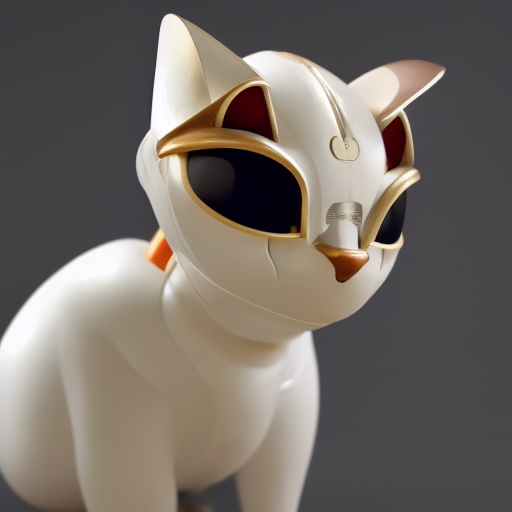

In [ ]:
#| server
file = {
    'created': 1666430223,
    'display_as_bot': False,
    'editable': False,
    'external_type': '',
    'file_access': 'visible',
    'filetype': 'png',
    'has_rich_preview': False,
    'id': 'F047NSV0EAF',
    'is_external': False,
    'is_public': False,
    'is_starred': False,
    'media_display_type': 'unknown',
    'mimetype': 'image/png',
    'mode': 'hosted',
    'name': 'A cat robot with its ears bitten off..png',
    'original_h': 512,
    'original_w': 512,
    'permalink': 'https://smartnews.slack.com/files/UB97SPZRT/F047NSV0EAF/a_cat_robot_with_its_ears_bitten_off..png',
    'permalink_public': 'https://slack-files.com/T02B9QAPR-F047NSV0EAF-26095ed8f7',
    'pretty_type': 'PNG',
    'public_url_shared': False,
    'size': 250474,
    'thumb_160': 'https://files.slack.com/files-tmb/T02B9QAPR-F047NSV0EAF-a1b3e5315a/a_cat_robot_with_its_ears_bitten_off._160.png',
    'thumb_360': 'https://files.slack.com/files-tmb/T02B9QAPR-F047NSV0EAF-a1b3e5315a/a_cat_robot_with_its_ears_bitten_off._360.png',
    'thumb_360_h': 360,
    'thumb_360_w': 360,
    'thumb_480': 'https://files.slack.com/files-tmb/T02B9QAPR-F047NSV0EAF-a1b3e5315a/a_cat_robot_with_its_ears_bitten_off._480.png',
    'thumb_480_h': 480,
    'thumb_480_w': 480,
    'thumb_64': 'https://files.slack.com/files-tmb/T02B9QAPR-F047NSV0EAF-a1b3e5315a/a_cat_robot_with_its_ears_bitten_off._64.png',
    'thumb_80': 'https://files.slack.com/files-tmb/T02B9QAPR-F047NSV0EAF-a1b3e5315a/a_cat_robot_with_its_ears_bitten_off._80.png',
    'thumb_tiny': 'AwAwADCrT4VDzIpGQTzTKntB+/Df3eaAHz26+YfLwB6HpTZLSRBkYYf7NMupSzspfZzyMGrNsx8tcMGGMZBpXHYqiCQru2nHqaYQQcHqKu3UjqEA6Nnn0xVKmIKngSWNw5QhT1J9Knt4BCgkkGXPIB7U5593BGRQwKdzAZGLKeT1BotUeHfv4Bxjmp2bc2aRj8p3dKkYXMko+UAhe5qrUskm5VReFX9ajqhF+V8vioaaZQxBzTu9IYDBPNST7fszAdiKriUbsD1p0zfugPU0ICCiiimI/9k=',
    'timestamp': 1666430223,
    'title': 'A cat robot with its ears bitten off..png',
    'url_private': 'https://files.slack.com/files-pri/T02B9QAPR-F047NSV0EAF/a_cat_robot_with_its_ears_bitten_off..png',
    'url_private_download': 'https://files.slack.com/files-pri/T02B9QAPR-F047NSV0EAF/download/a_cat_robot_with_its_ears_bitten_off..png',
    'user': 'UB97SPZRT',
    'user_team': 'T02B9QAPR',
    'username': ''
}
token = os.environ['SLACK_OAUTH_TOKEN']
image = get_image_from_file(file, token=token)
image

# build_blocks

In [ ]:
#| export
def build_blocks(user_id: str, model_params: str, image_url: str) -> list:
    p = model_params
    logger.info(f"model_params: {pformat(p)}")
    prompt = p['prompt']
    
    b_user_mention = {
        "type": "section",
        "text": {
            "type": "mrkdwn",
            f"text": f"<@{user_id}>, here is your artwork :smartart: meow!"
        }
    }
    
    b_divider = {"type": "divider"}
    
    b_prompt = {
        "type": "section",
        "text": {
            "type": "mrkdwn",
            "text": prompt
        }
    }
    
    oneline_details = ""
    for k in ['steps', 'cfg', 'seed']:
        oneline_details += f"{k}:{p[k]} "
    
    b_config = {
        "type": "section",
        "text": {
            "type": "mrkdwn",
            "text": f"*{oneline_details}*"
        }
    }
    
    blocks = [
        b_user_mention,
        b_divider,
        b_prompt,
        b_config
    ]
    
    if p.get("negative_prompt", None):
        blocks.append({
            "type": "section",
            "text": {
                "type": "mrkdwn",
                "text": f"~{p['negative_prompt']}~"
            }
        })
        
    image_caption = prompt[:30] + '..' if len(prompt) > 30 else prompt

    b_image = {
        "type": "image",
        "title": {
            "type": "plain_text",
            "text": image_caption,
            "emoji": True
        },
        "image_url": image_url,
        "alt_text": image_caption
    }
    
    blocks.append(b_image)

    return blocks
    

In [ ]:
user_id = "UB97SPZRT"
model_params = {
    "prompt": "this is a easy prompt",
    "steps": 10,
    "cfg": 6.5,
    "seed": 123,
    "negative_prompt": "bad",
}
image_url = "https://assets3.thrillist.com/v1/image/1682388/size/tl-horizontal_main.jpg"

blocks = build_blocks(user_id, model_params, image_url)
print(pformat(blocks))

[{'text': {'text': '<@UB97SPZRT>, here is your artwork :smartart: meow!',
           'type': 'mrkdwn'},
  'type': 'section'},
 {'type': 'divider'},
 {'text': {'text': 'this is a easy prompt', 'type': 'mrkdwn'},
  'type': 'section'},
 {'text': {'text': '*steps:10 cfg:6.5 seed:123 *', 'type': 'mrkdwn'},
  'type': 'section'},
 {'text': {'text': '~bad~', 'type': 'mrkdwn'}, 'type': 'section'},
 {'alt_text': 'this is a easy prompt',
  'image_url': 'https://assets3.thrillist.com/v1/image/1682388/size/tl-horizontal_main.jpg',
  'title': {'emoji': True,
            'text': 'this is a easy prompt',
            'type': 'plain_text'},
  'type': 'image'}]


# parse_app_mention_outer_event

In [ ]:
#| export
# @pysnooper.snoop()
def parse_app_mention_outer_event(outer_event: dict) -> dict:
    auth_info = outer_event['authorizations'][0]
    bot_user_id = auth_info['user_id']
    d = {}
    
    e = outer_event['event']
    if e['type'] != 'app_mention':
        raise NotImplementedError(pformat(e))
    
    for b in e['blocks']:
        if b['type'] != 'rich_text':
            raise NotImplementedError(pformat(b))
        
        dd = parse_rich_text(b, bot_user_id=bot_user_id)
        logger.info(f"Result from parsing block: {pformat(b)}")
        logger.info(pformat(dd))
        
        d.update(dd)
    
    for k in INTERMEDIATE_KEYS:
        if k == NS and k in d:
            logging.info(d[NS])
            d[NP] = " ".join(d[NS])
            
        d.pop(k, None)
        
    orig_d = dict(d)
    for k, v in orig_d.items():
        try:
            d[k] = int(v)

        except ValueError:
            try:
                d[k] = float(v)
            except ValueError:
                continue
                
    # image
    files = e.get('files', [])
    if files:
        logger.info("File detected, try downloading.")
        if len(files) > 1:
            logger.info(f"{len(files)} detected. only use first file as image")
        
        file = files[0]
        token = os.environ['SLACK_BOT_TOKEN']
        image: PIL.PngImagePlugin.PngImageFile = get_image_from_file(file, token=token)
        d['init_image'] = image                 
    
    return d

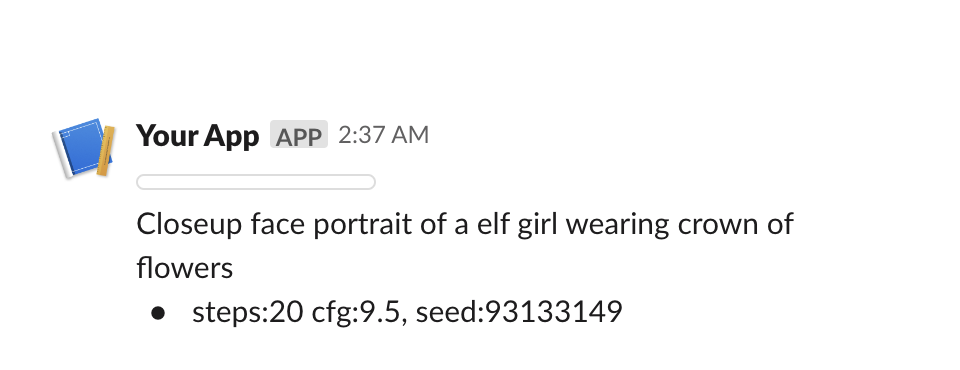

- [Block Kit Builder](https://app.slack.com/block-kit-builder/T0W4GV482#%7B%22blocks%22:%5B%7B%22block_id%22:%22kMFy/%22,%22elements%22:%5B%7B%22elements%22:%5B%7B%22type%22:%22user%22,%22user_id%22:%22U046NC74JTV%22%7D,%7B%22text%22:%22%5CnCloseup%20face%20portrait%20of%20a%20elf%20girl%20wearing%20crown%20of%20flowers%22,%22type%22:%22text%22%7D%5D,%22type%22:%22rich_text_section%22%7D,%7B%22border%22:0,%22elements%22:%5B%7B%22elements%22:%5B%7B%22text%22:%22steps:20%20cfg:9.5,%20seed:93133149%22,%22type%22:%22text%22%7D%5D,%22type%22:%22rich_text_section%22%7D%5D,%22indent%22:0,%22style%22:%22bullet%22,%22type%22:%22rich_text_list%22%7D%5D,%22type%22:%22rich_text%22%7D%5D%7D)

In [ ]:
e = {
    "api_app_id": "A046KFTF1DK",
    "authorizations": [
        {
            "enterprise_id": None,
            "is_bot": True,
            "is_enterprise_install": False,
            "team_id": "T02B9QAPR",
            "user_id": "U046NC74JTV"
        }
    ],
    "event": {
        "blocks": [
            {
                "block_id": "kMFy/",
                "elements": [
                    {
                        "elements": [
                            {
                                "type": "user",
                                "user_id": "U046NC74JTV"
                            },
                            {
                                "text": "\nCloseup face portrait of a elf girl wearing crown of flowers",
                                "type": "text"
                            }
                        ],
                        "type": "rich_text_section"
                    },
                    {
                        "border": 0,
                        "elements": [
                            {
                                "elements": [
                                    {
                                        "text": "steps:20 cfg:9.5 seed:93133149",
                                        "type": "text"
                                    }
                                ],
                                "type": "rich_text_section"
                            }
                        ],
                        "indent": 0,
                        "style": "bullet",
                        "type": "rich_text_list"
                    }
                ],
                "type": "rich_text"
            }
        ],
        "channel": "C047C5MCP16",
        "event_ts": "1666501427.475059",
        "team": "T02B9QAPR",
        "ts": "1666501427.475059",
        "type": "app_mention",
        "user": "UB97SPZRT"
    },
    "event_context": "4-eyJldCI6ImFwcF9tZW50aW9uIiwidGlkIjoiVDAyQjlRQVBSIiwiYWlkIjoiQTA0NktGVEYxREsiLCJjaWQiOiJDMDQ3QzVNQ1AxNiJ9",
    "event_id": "Ev047M57AYTF",
    "event_time": 1666501427,
    "is_ext_shared_channel": False,
    "team_id": "T02B9QAPR",
    "token": "0U1py6C0RfpJB9Syo6D2hlOu",
    "type": "event_callback"
}

d = parse_app_mention_outer_event(e)
d
assert d == {'prompt': 'Closeup face portrait of a elf girl wearing crown of flowers',
 'steps': 20,
 'cfg': 9.5,
 'seed': 93133149}

INFO:root:Partial result from parsing {'elements': [{'type': 'user', 'user_id': 'U046NC74JTV'},
              {'text': '\n'
                       'Closeup face portrait of a elf girl wearing crown of '
                       'flowers',
               'type': 'text'}],
 'type': 'rich_text_section'}:
INFO:root:{'gathering': True,
 'prompt': 'Closeup face portrait of a elf girl wearing crown of flowers'}
INFO:root:try parsing key value using : separator.
INFO:root:Partial result from parsing {'border': 0,
 'elements': [{'elements': [{'text': 'steps:20 cfg:9.5 seed:93133149',
                             'type': 'text'}],
               'type': 'rich_text_section'}],
 'indent': 0,
 'style': 'bullet',
 'type': 'rich_text_list'}:
INFO:root:{'cfg': '9.5', 'seed': '93133149', 'steps': '20'}
INFO:root:Result by parsing `rich_text` element:
INFO:root:{'cfg': '9.5',
 'gathering': True,
 'prompt': 'Closeup face portrait of a elf girl wearing crown of flowers',
 'seed': '93133149',
 'steps': '20'}

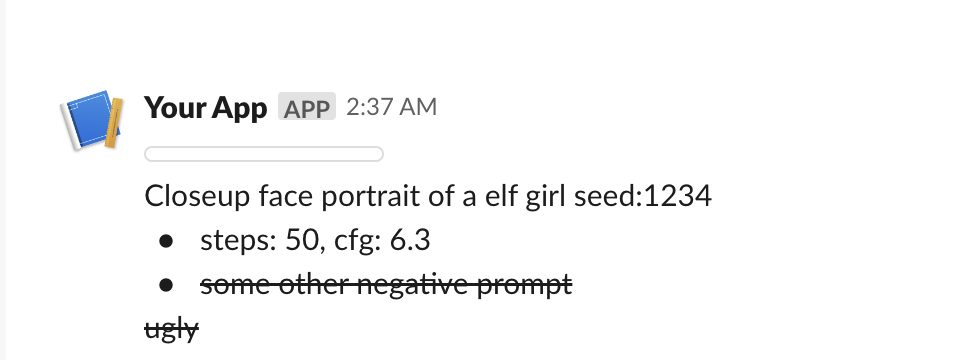

- [Block Kit Builder](https://app.slack.com/block-kit-builder/T0W4GV482#%7B%22blocks%22:%5B%7B%22block_id%22:%22SBAnR%22,%22elements%22:%5B%7B%22elements%22:%5B%7B%22type%22:%22user%22,%22user_id%22:%22U046NC74JTV%22%7D,%7B%22text%22:%22%5CnCloseup%20face%20portrait%20of%20a%20elf%20girl%20seed:1234%5Cn%22,%22type%22:%22text%22%7D%5D,%22type%22:%22rich_text_section%22%7D,%7B%22border%22:0,%22elements%22:%5B%7B%22elements%22:%5B%7B%22text%22:%22steps:%2050,%20cfg:%206.3%22,%22type%22:%22text%22%7D%5D,%22type%22:%22rich_text_section%22%7D%5D,%22indent%22:0,%22style%22:%22bullet%22,%22type%22:%22rich_text_list%22%7D,%7B%22border%22:0,%22elements%22:%5B%7B%22elements%22:%5B%7B%22style%22:%7B%22strike%22:true%7D,%22text%22:%22some%20other%20negative%20prompt%22,%22type%22:%22text%22%7D%5D,%22type%22:%22rich_text_section%22%7D%5D,%22indent%22:0,%22style%22:%22bullet%22,%22type%22:%22rich_text_list%22%7D,%7B%22elements%22:%5B%7B%22style%22:%7B%22strike%22:true%7D,%22text%22:%22ugly%22,%22type%22:%22text%22%7D%5D,%22type%22:%22rich_text_section%22%7D%5D,%22type%22:%22rich_text%22%7D%5D%7D)

In [ ]:
e = {'api_app_id': 'A046KFTF1DK',
 'authorizations': [{'enterprise_id': None,
                     'is_bot': True,
                     'is_enterprise_install': False,
                     'team_id': 'T02B9QAPR',
                     'user_id': 'U046NC74JTV'}],
 'event': {'blocks': [{'block_id': 'SBAnR',
                       'elements': [{'elements': [{'type': 'user',
                                                   'user_id': 'U046NC74JTV'},
                                                  {'text': '\n'
                                                           'Closeup face '
                                                           'portrait of a elf '
                                                           'girl seed:1234\n',
                                                   'type': 'text'}],
                                     'type': 'rich_text_section'},
                                    {'border': 0,
                                     'elements': [{'elements': [{'text': 'steps: '
                                                                         '50, '
                                                                         'cfg: '
                                                                         '6.3',
                                                                 'type': 'text'}],
                                                   'type': 'rich_text_section'}],
                                     'indent': 0,
                                     'style': 'bullet',
                                     'type': 'rich_text_list'},
                                    {
                                        "border": 0,
                                        "elements": [
                                            {
                                                "elements": [
                                                    {
                                                        "style": {
                                                            "strike": True
                                                        },
                                                        "text": "some other negative prompt",
                                                        "type": "text"
                                                    }
                                                ],
                                                "type": "rich_text_section"
                                            }
                                        ],
                                        "indent": 0,
                                        "style": "bullet",
                                        "type": "rich_text_list"
                                    },
                                    {'elements': [{'style': {'strike': True},
                                                   'text': 'ugly',
                                                   'type': 'text'}],
                                     'type': 'rich_text_section'}],
                       'type': 'rich_text'}],
           'channel': 'C047C5MCP16',
           'client_msg_id': '3edc450d-3cf4-46fd-8033-c28c220565a5',
           'event_ts': '1666503589.565399',
           'team': 'T02B9QAPR',
           'text': '<@U046NC74JTV>\n'
                   'Closeup face portrait of a elf girl seed:1234\n'
                   '• steps: 50, cfg: 6.3\n'
                   '~ugly~',
           'ts': '1666503589.565399',
           'type': 'app_mention',
           'user': 'UB97SPZRT'},
 'event_context': '4-eyJldCI6ImFwcF9tZW50aW9uIiwidGlkIjoiVDAyQjlRQVBSIiwiYWlkIjoiQTA0NktGVEYxREsiLCJjaWQiOiJDMDQ3QzVNQ1AxNiJ9',
 'event_id': 'Ev047Q27MCTD',
 'event_time': 1666503589,
 'is_ext_shared_channel': False,
 'team_id': 'T02B9QAPR',
 'token': '0U1py6C0RfpJB9Syo6D2hlOu',
 'type': 'event_callback'}

d = parse_app_mention_outer_event(e)
d
assert d == {'seed': 1234,
 'prompt': 'Closeup face portrait of a elf girl',
 'steps': 50,
 'cfg': 6.3,
 'negative_prompt': 'some other negative prompt ugly'}

INFO:root:Partial result from parsing {'elements': [{'type': 'user', 'user_id': 'U046NC74JTV'},
              {'text': '\nCloseup face portrait of a elf girl seed:1234\n',
               'type': 'text'}],
 'type': 'rich_text_section'}:
INFO:root:{'gathering': True,
 'prompt': 'Closeup face portrait of a elf girl',
 'seed': '1234'}
INFO:root:try parsing key value using : separator.
INFO:root:Partial result from parsing {'border': 0,
 'elements': [{'elements': [{'text': 'steps: 50, cfg: 6.3', 'type': 'text'}],
               'type': 'rich_text_section'}],
 'indent': 0,
 'style': 'bullet',
 'type': 'rich_text_list'}:
INFO:root:{'cfg': '6.3', 'steps': '50'}
INFO:root:Found negative prompt.
INFO:root:Partial result from parsing {'border': 0,
 'elements': [{'elements': [{'style': {'strike': True},
                             'text': 'some other negative prompt',
                             'type': 'text'}],
               'type': 'rich_text_section'}],
 'indent': 0,
 'style': 'bullet',
 't

## test: with image

INFO:root:Partial result from parsing {'elements': [{'type': 'user', 'user_id': 'U046NC74JTV'},
              {'text': '\nCloseup face portrait of a elf girl seed:1234\n',
               'type': 'text'}],
 'type': 'rich_text_section'}:
INFO:root:{'gathering': True,
 'prompt': 'Closeup face portrait of a elf girl',
 'seed': '1234'}
INFO:root:try parsing key value using : separator.
INFO:root:Partial result from parsing {'border': 0,
 'elements': [{'elements': [{'text': 'steps: 50, cfg: 6.3', 'type': 'text'}],
               'type': 'rich_text_section'}],
 'indent': 0,
 'style': 'bullet',
 'type': 'rich_text_list'}:
INFO:root:{'cfg': '6.3', 'steps': '50'}
INFO:root:Found negative prompt.
INFO:root:Partial result from parsing {'elements': [{'style': {'strike': True}, 'text': 'ugly', 'type': 'text'}],
 'type': 'rich_text_section'}:
INFO:root:{'negative_sentences': ['ugly']}
INFO:root:Result by parsing `rich_text` element:
INFO:root:{'cfg': '6.3',
 'gathering': True,
 'negative_sentences': 

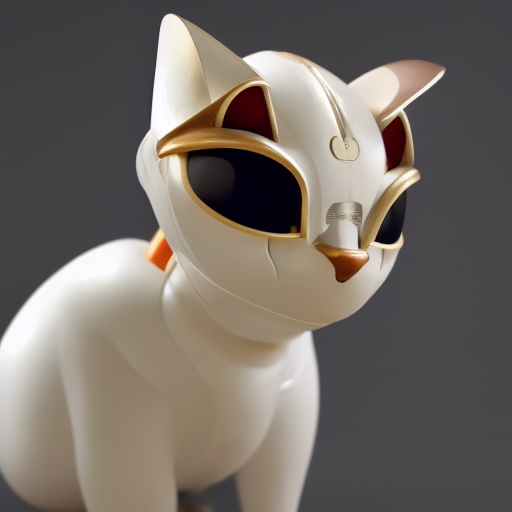

In [ ]:
#| server
e = {'api_app_id': 'A046KFTF1DK',
 'authorizations': [{'enterprise_id': None,
                     'is_bot': True,
                     'is_enterprise_install': False,
                     'team_id': 'T02B9QAPR',
                     'user_id': 'U046NC74JTV'}],
 'event': {'blocks': [{'block_id': 'M0G',
                       'elements': [{'elements': [{'type': 'user',
                                                   'user_id': 'U046NC74JTV'},
                                                  {'text': '\n'
                                                           'Closeup face '
                                                           'portrait of a elf '
                                                           'girl seed:1234\n',
                                                   'type': 'text'}],
                                     'type': 'rich_text_section'},
                                    {'border': 0,
                                     'elements': [{'elements': [{'text': 'steps: '
                                                                         '50, '
                                                                         'cfg: '
                                                                         '6.3',
                                                                 'type': 'text'}],
                                                   'type': 'rich_text_section'}],
                                     'indent': 0,
                                     'style': 'bullet',
                                     'type': 'rich_text_list'},
                                    {'elements': [{'style': {'strike': True},
                                                   'text': 'ugly',
                                                   'type': 'text'}],
                                     'type': 'rich_text_section'}],
                       'type': 'rich_text'}],
           'channel': 'C047C5MCP16',
           'client_msg_id': 'd15e2371-cecc-42b4-b2bb-47ffa5544613',
           'display_as_bot': False,
           'event_ts': '1666504728.015459',
           'files': [{'created': 1666504720,
                      'display_as_bot': False,
                      'editable': False,
                      'external_type': '',
                      'file_access': 'visible',
                      'filetype': 'png',
                      'has_rich_preview': False,
                      'id': 'F0482PRBJRF',
                      'is_external': False,
                      'is_public': False,
                      'is_starred': False,
                      'media_display_type': 'unknown',
                      'mimetype': 'image/png',
                      'mode': 'hosted',
                      'name': 'A cat robot with its ears bitten off..png',
                      'original_h': 512,
                      'original_w': 512,
                      'permalink': 'https://smartnews.slack.com/files/UB97SPZRT/F0482PRBJRF/a_cat_robot_with_its_ears_bitten_off..png',
                      'permalink_public': 'https://slack-files.com/T02B9QAPR-F0482PRBJRF-d104414b71',
                      'pretty_type': 'PNG',
                      'public_url_shared': False,
                      'size': 250474,
                      'timestamp': 1666504720,
                      'title': 'A cat robot with its ears bitten off..png',
                      'url_private': 'https://files.slack.com/files-pri/T02B9QAPR-F0482PRBJRF/a_cat_robot_with_its_ears_bitten_off..png',
                      'url_private_download': 'https://files.slack.com/files-pri/T02B9QAPR-F0482PRBJRF/download/a_cat_robot_with_its_ears_bitten_off..png',
                      'user': 'UB97SPZRT',
                      'user_team': 'T02B9QAPR',
                      'username': ''}],
           'text': '<@U046NC74JTV>\n'
                   'Closeup face portrait of a elf girl seed:1234\n'
                   '• steps: 50, cfg: 6.3\n'
                   '~ugly~',
           'ts': '1666504728.015459',
           'type': 'app_mention',
           'upload': False,
           'user': 'UB97SPZRT'},
 'event_context': '4-eyJldCI6ImFwcF9tZW50aW9uIiwidGlkIjoiVDAyQjlRQVBSIiwiYWlkIjoiQTA0NktGVEYxREsiLCJjaWQiOiJDMDQ3QzVNQ1AxNiJ9',
 'event_id': 'Ev0479JABXEK',
 'event_time': 1666504728,
 'is_ext_shared_channel': False,
 'team_id': 'T02B9QAPR',
 'token': '0U1py6C0RfpJB9Syo6D2hlOu',
 'type': 'event_callback'}

d = parse_app_mention_outer_event(e)
init_image = d.pop("init_image")
assert d == {'seed': 1234,
 'prompt': 'Closeup face portrait of a elf girl',
 'steps': 50,
 'cfg': 6.3,
 'negative_prompt': 'ugly'}
assert type(init_image) is PIL.PngImagePlugin.PngImageFile
init_image

In [ ]:
init_image.s

In [ ]:
# print(json.dumps(e, indent=4))

In [ ]:
e = {'api_app_id': 'A046KFTF1DK',
 'authorizations': [{'enterprise_id': None,
                     'is_bot': True,
                     'is_enterprise_install': False,
                     'team_id': 'T02B9QAPR',
                     'user_id': 'U046NC74JTV'}],
 'event': {'blocks': [{'block_id': 'KhvzX',
                       'elements': [{'elements': [{'type': 'user',
                                                   'user_id': 'U046NC74JTV'},
                                                  {'text': ' prompt\n',
                                                   'type': 'text'}],
                                     'type': 'rich_text_section'},
                                    {'border': 0,
                                     'elements': [{'elements': [{'text': '123',
                                                                 'type': 'text'}],
                                                   'type': 'rich_text_section'},
                                                  {'elements': [{'text': 'seed: '
                                                                         '456',
                                                                 'type': 'text'}],
                                                   'type': 'rich_text_section'}],
                                     'indent': 0,
                                     'style': 'bullet',
                                     'type': 'rich_text_list'}],
                       'type': 'rich_text'}],
           'channel': 'C047C5MCP16',
           'client_msg_id': 'd9a528e1-e094-4941-8e3d-05c6d7dfadf2',
           'event_ts': '1666508084.235389',
           'team': 'T02B9QAPR',
           'text': '<@U046NC74JTV> prompt\n• 123\n• seed: 456',
           'ts': '1666508084.235389',
           'type': 'app_mention',
           'user': 'UB97SPZRT'},
 'event_context': '4-eyJldCI6ImFwcF9tZW50aW9uIiwidGlkIjoiVDAyQjlRQVBSIiwiYWlkIjoiQTA0NktGVEYxREsiLCJjaWQiOiJDMDQ3QzVNQ1AxNiJ9',
 'event_id': 'Ev047Q6E0E2E',
 'event_time': 1666508084,
 'is_ext_shared_channel': False,
 'team_id': 'T02B9QAPR',
 'token': '0U1py6C0RfpJB9Syo6D2hlOu',
 'type': 'event_callback'}

d = parse_app_mention_outer_event(e)
d

INFO:root:Partial result from parsing {'elements': [{'type': 'user', 'user_id': 'U046NC74JTV'},
              {'text': ' prompt\n', 'type': 'text'}],
 'type': 'rich_text_section'}:
INFO:root:{'gathering': True, 'prompt': 'prompt'}
INFO:root:try parsing key value using : separator.
INFO:root:try parsing key value using : separator.
INFO:root:Partial result from parsing {'border': 0,
 'elements': [{'elements': [{'text': '123', 'type': 'text'}],
               'type': 'rich_text_section'},
              {'elements': [{'text': 'seed: 456', 'type': 'text'}],
               'type': 'rich_text_section'}],
 'indent': 0,
 'style': 'bullet',
 'type': 'rich_text_list'}:
INFO:root:{'seed': '456'}
INFO:root:Result by parsing `rich_text` element:
INFO:root:{'gathering': True, 'prompt': 'prompt', 'seed': '456'}
INFO:root:Result from parsing block: {'block_id': 'KhvzX',
 'elements': [{'elements': [{'type': 'user', 'user_id': 'U046NC74JTV'},
                            {'text': ' prompt\n', 'type': 'te

{'prompt': 'prompt', 'seed': 456}

# handle_app_mention_event

In [ ]:
#| export 
import boto3
S3_BUCKET_NAME = "hackathon2022-smartart"

def upload_image_to_s3(id, user_id, buffer, env="prd"):
    s3 = boto3.resource('s3')
    object_key = f'''{env}/images/{user_id}/{id}.png'''
    s3.Bucket(S3_BUCKET_NAME).put_object(
        Key=object_key,
        Body=buffer,
        ContentType='image/png',
    )
    return f'''s3://{S3_BUCKET_NAME}/{object_key}''' 

In [ ]:
#| export
import tempfile
from smartart.slack.utils import get_user_info, get_conversation_info

def handle_app_mention_event(body, client, logger, model_endpoint):
    log_event = {}
    outer_event = body
    logger.info("outer_event:")
    logger.info(pformat(outer_event))

    params = parse_app_mention_outer_event(outer_event)
    logger.info(pformat(params))
    
    event = outer_event['event']
    text = event['text']
    channel = event['channel']
    user_id = event['user']
    
    # return
    
    
#     user = get_user_info(user_id, client, logger)
#     log_event['user'] = user
#     if user['is_bot']:
#         logger.info("request from bot user, ignored")
#         return
    
#     conversation = get_conversation_info(channel, client, logger)
#     log_event['conversation'] = conversation
    
    
    prompt = params['prompt']
    params['steps'] = params.get("steps", 50)
    params['cfg'] = params.get('cfg', 7.5)
    params['guidance_scale'] = params['cfg']
    
    
    short_prompt = (prompt[:50] + '..') if len(prompt) > 50 else prompt

    resp = requests.post(
        model_endpoint,
        headers={"Content-Type": "application/json"},
        json=params
    )
    j = resp.json()
    logger.info(j.keys())
    
    image_data = j['images'][0]
    params['seed'] = j['seed']
    
    image = Image.open(io.BytesIO(
        base64.decodebytes(bytes(image_data, "utf-8"))))
    
    tempdir = tempfile.gettempdir()
    file_path = os.path.join(tempdir, f'''{short_prompt}.png''')
    image.save(file_path)
    buffer = io.BytesIO()
    image.save(buffer, "PNG")
    buffer.seek(0) # rewind pointer back to start
    
    
    # id = uuid.uuid4().hex
    # try:
    #     # TODO: use `env` arg to control the place to save images
    #     image_s3_url = upload_image_to_s3(id, user_id, buffer)
    #     logger.info(image_s3_url)
    # except Exception as e:
    #     image_s3_url = ''
    #     logger.error("Error in upload image to s3", e)
    
#     blocks = build_blocks(user_id, params, image_s3_url)
        
#     client.chat_postMessage(
#         channel=channel, 
#         blocks=blocks
#     )


    oneline_details = ""
    for k in ['steps', 'cfg', 'seed']:
        oneline_details += f"{k}:{params[k]} "


    initial_comment = f"""<@{user_id}>, your artwork is ready :smartart:\n{prompt}\n*{oneline_details}*""".strip()
    
    np = params.get("negative_prompt", None)
    if np:
        initial_comment += "\n~" + np + "~"


    file_response = client.files_upload(
        file=file_path,
        channels=[channel],
        initial_comment=initial_comment,
    )
    

    

In [ ]:
#| server
from smartart.slack.utils import get_app

app = get_app(
    workspace='smartnews',
    bot='smartart-dev',
)

client = app.client

json.dumps(blocks)

client.chat_postMessage(
    channel='C047C5MCP16', 
    blocks=blocks
)

In [ ]:
# [{'text': {'text': '',
#            'type': 'mrkdwn'},
#   'type': 'section'},
#  {'type': 'divider'},
#  {'text': {'text': 'this is a easy prompt', 'type': 'mrkdwn'},
#   'type': 'section'},
#  {'text': {'text': '*steps:10 cfg:6.5 seed:123 *', 'type': 'mrkdwn'},
#   'type': 'section'},
#  {'text': {'text': '~bad~', 'type': 'mrkdwn'}, 'type': 'section'},
#  {'alt_text': 'this is a easy prompt',
#   'image_url': 'https://assets3.thrillist.com/v1/image/1682388/size/tl-horizontal_main.jpg',
#   'title': {'emoji': True,
#             'text': 'this is a easy prompt',
#             'type': 'plain_text'},
#   'type': 'image'}]

In [ ]:
# #| server
# file_path = "/Users/meng.lee/Documents/images/meng.gif"
# file_response = client.files_upload(
#     file=file_path,
#     channels=['C047C5MCP16'],
#     initial_comment="~kj~, *SDF*",
# )

# end

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()